<a href="https://colab.research.google.com/github/pscabral/IFMA_Softex/blob/main/mobilenetv2_2.00_160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import gdown

# Especifique o ID do arquivo e o nome do arquivo de saída
file_id = '1aX48j7lKyE0c66tMZEesOwNncFbyvu6X'
output = 'dataset.zip'

# Baixe o arquivo do Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
!unzip dataset.zip

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/dataset_3'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
train_dir = '/content/dataset_3/train'
test_dir = '/content/dataset_3/train'
val_dir = '/content/dataset_3/validation'

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
# Create a list with the filepaths for training and testing
train_dir = Path('../content/dataset_3/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../content/dataset_3/train')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures: 2780

Number of different labels: 36

Labels: ['spinach' 'beetroot' 'lettuce' 'eggplant' 'potato' 'bell pepper'
 'pomegranate' 'capsicum' 'ginger' 'pineapple' 'corn' 'mango' 'apple'
 'paprika' 'peas' 'carrot' 'turnip' 'sweetcorn' 'garlic' 'watermelon'
 'grapes' 'cabbage' 'lemon' 'soy beans' 'cucumber' 'tomato'
 'chilli pepper' 'pear' 'onion' 'orange' 'sweetpotato' 'kiwi'
 'cauliflower' 'raddish' 'jalepeno' 'banana']


Filepath     Label
0   ../content/dataset_3/train/spinach/Image_65.jpg   spinach
1   ../content/dataset_3/train/spinach/Image_36.jpg   spinach
2  ../content/dataset_3/train/beetroot/Image_38.jpg  beetroot
3   ../content/dataset_3/train/lettuce/Image_26.jpg   lettuce
4  ../content/dataset_3/train/eggplant/Image_69.jpg  eggplant

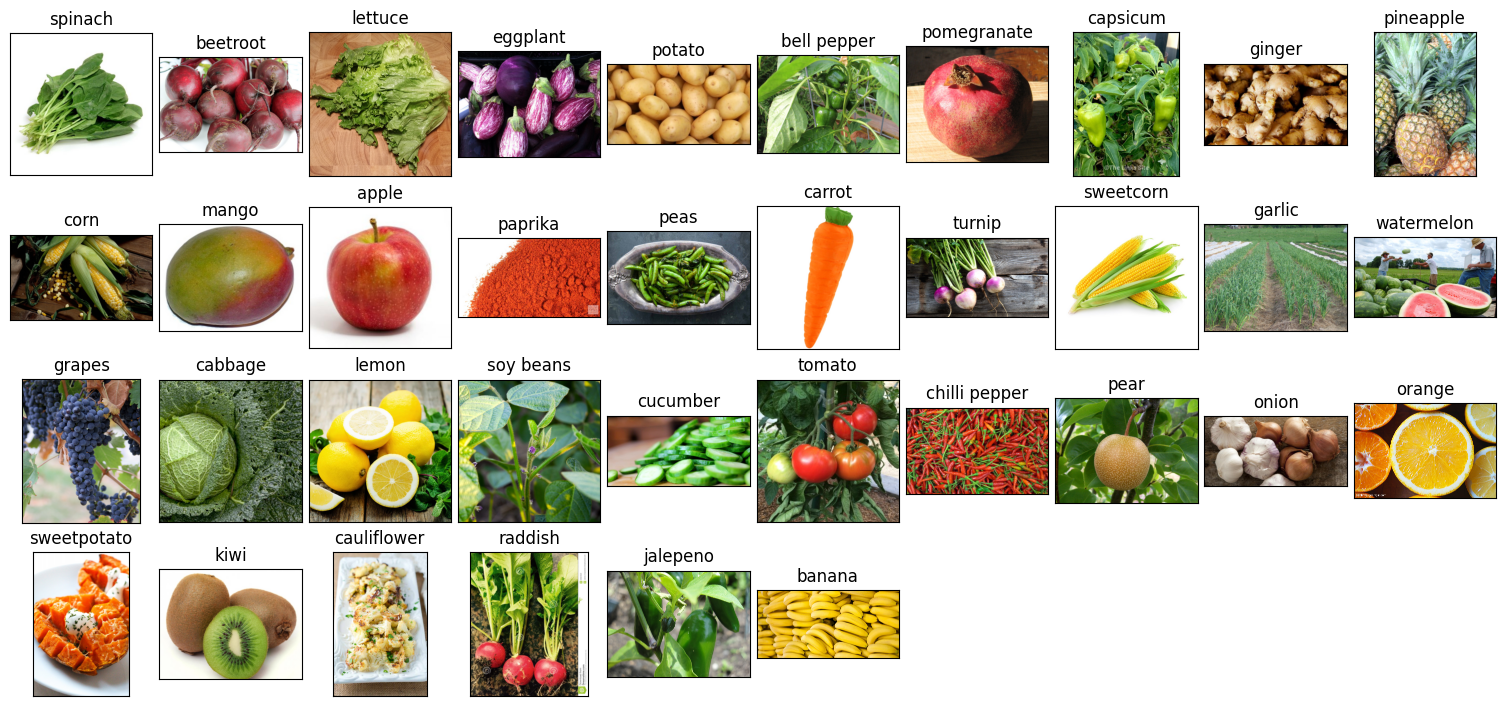

In [10]:
# Create a DataFrame with one Label of each category
df_unique = train_df.drop_duplicates(subset=["Label"]).reset_index(drop=True)

# Display some pictures of the dataset
n_rows = 4
n_cols = 10
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        ax.axis('off')  # Turn off empty subplots

plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2224 validated image filenames belonging to 36 classes.
Found 556 validated image filenames belonging to 36 classes.
Found 2780 validated image filenames belonging to 36 classes.


In [12]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [33]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10
)

Epoch 1/10
70/70 [==============================] - 191s 3s/step - loss: 2.0136 - accuracy: 0.4717 - val_loss: 0.9637 - val_accuracy: 0.7014
Epoch 2/10
70/70 [==============================] - 173s 2s/step - loss: 0.6158 - accuracy: 0.8013 - val_loss: 0.7862 - val_accuracy: 0.7698
Epoch 3/10
70/70 [==============================] - 172s 2s/step - loss: 0.3338 - accuracy: 0.9042 - val_loss: 0.7702 - val_accuracy: 0.7608
Epoch 4/10
70/70 [==============================] - 164s 2s/step - loss: 0.2078 - accuracy: 0.9388 - val_loss: 0.7294 - val_accuracy: 0.7896
Epoch 5/10
70/70 [==============================] - 171s 2s/step - loss: 0.1425 - accuracy: 0.9577 - val_loss: 0.7359 - val_accuracy: 0.7842
Epoch 6/10
70/70 [==============================] - 172s 2s/step - loss: 0.0969 - accuracy: 0.9744 - val_loss: 0.7416 - val_accuracy: 0.7860
Epoch 7/10
70/70 [==============================] - 172s 2s/step - loss: 0.0708 - accuracy: 0.9816 - val_loss: 0.7894 - val_accuracy: 0.7968
Epoch 8/10
70

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

59/87 [===================>..........] - ETA: 55s

In [27]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 92.95%


In [28]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

               precision    recall  f1-score   support

        apple       0.83      0.95      0.89        58
       banana       1.00      0.98      0.99        62
     beetroot       0.97      0.99      0.98        84
  bell pepper       0.71      0.91      0.80        78
      cabbage       0.97      1.00      0.98        84
     capsicum       0.93      0.49      0.64        80
       carrot       0.99      0.96      0.97        73
  cauliflower       1.00      0.97      0.99        71
chilli pepper       0.94      0.88      0.91        76
         corn       0.96      0.51      0.67        84
     cucumber       0.99      0.95      0.97        78
     eggplant       0.97      0.92      0.95        77
       garlic       0.99      0.98      0.98        83
       ginger       0.95      0.98      0.97        64
       grapes       0.99      0.98      0.98        85
     jalepeno       0.88      0.94      0.91        79
         kiwi       1.00      0.99      0.99        82
        l

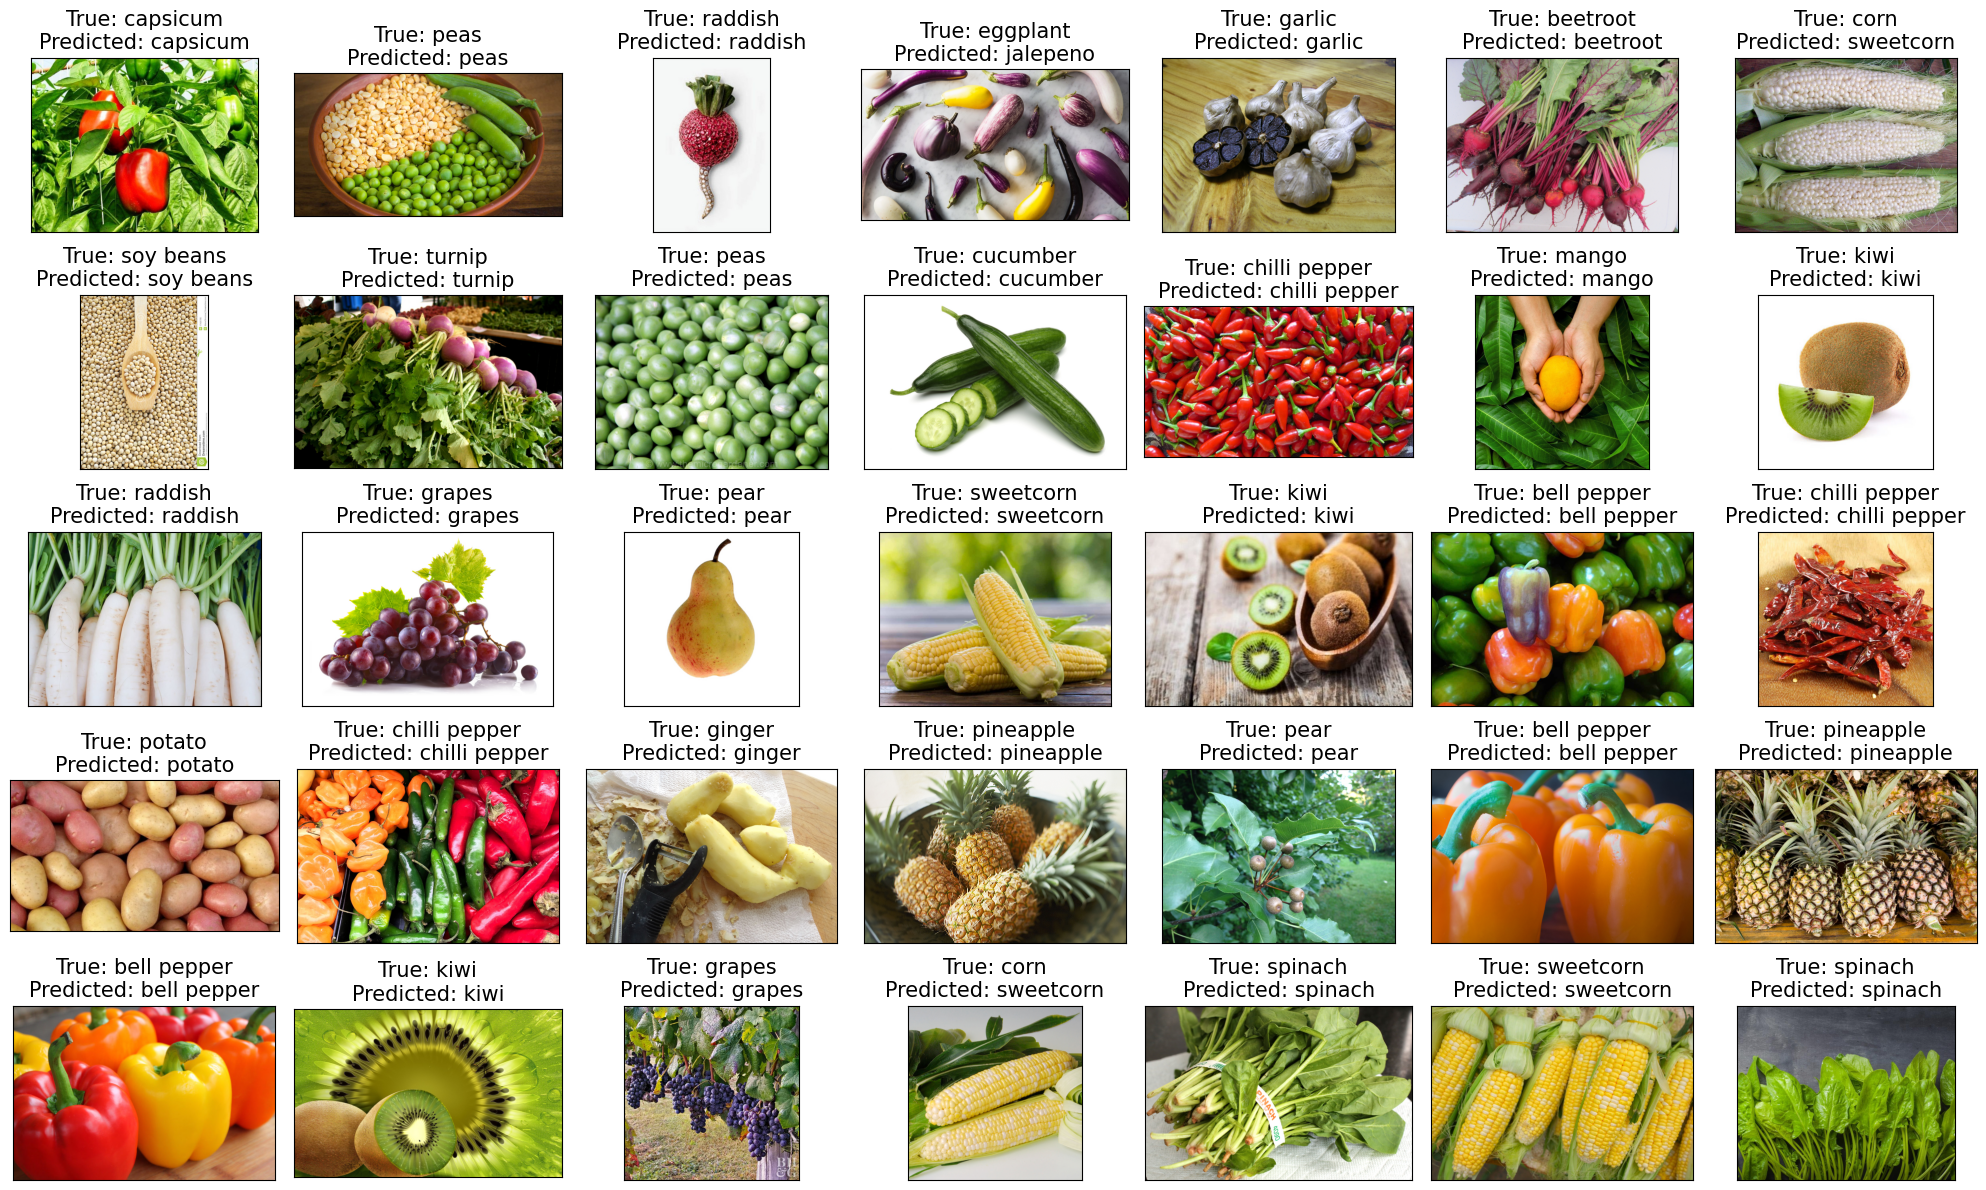

In [29]:
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [30]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

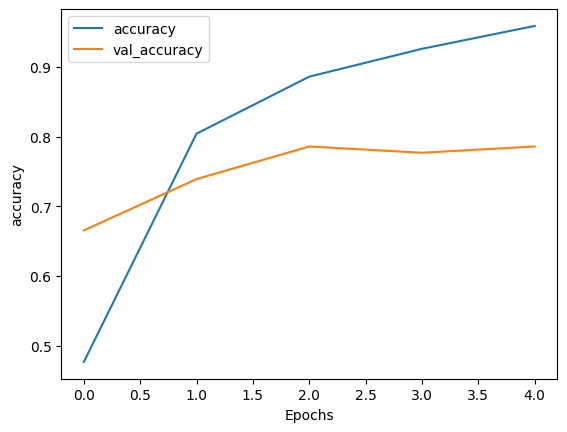

In [31]:
plot_graghs(history, 'accuracy')

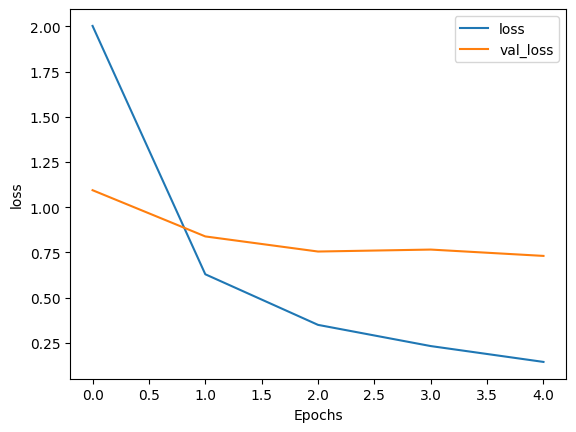

In [32]:
plot_graghs(history, 'loss')

In [ ]:
#!pip install gTTS
import cv2
import numpy as np
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow
from gtts import gTTS
import IPython.display as ipd

# Caminho para a imagem de teste
caminho_imagem_teste = '/content/OIP (4).jpg'  # Substitua pelo caminho da sua imagem de teste

# Ler a imagem de teste
image = cv2.imread(caminho_imagem_teste)

# Redimensionar a imagem para o tamanho esperado pela MobileNetV2
image_resized = cv2.resize(image, (224, 224))

# Adicionar a dimensão do lote (batch)
image_resized = np.expand_dims(image_resized, axis=0)

# Pré-processamento específico da MobileNetV2
image_preprocessed = preprocess_input(image_resized)

# Carregar o modelo MobileNetV2
model = MobileNetV2(weights='imagenet')

# Fazer a previsão usando o modelo MobileNetV2
predicted_label = model.predict(image_preprocessed)

# Decodificar o rótulo previsto para obter as principais previsões
predicted_labels = decode_predictions(predicted_label, top=3)[0]

# Exibir as previsões
for i, (imagenet_id, label, score) in enumerate(predicted_labels):
    print(f"Previsão {i + 1}: {label} ({score:.2f})")

# Gerar o arquivo de áudio com o nome do produto previsto
predicted_class = predicted_labels[0][1]  # Usando a previsão principal
tts = gTTS(text=f'O produto é {predicted_class}', lang='pt')
tts.save('/content/prevision.mp3')

# Reproduzir o arquivo de áudio
ipd.Audio('/content/prevision.mp3')
